In [49]:
import sys
sys.path.append('../')
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from funcs.analysis.analysis import analysis
import celerite
from celerite import terms
%matplotlib inline

wdir = '/disk1/hrb/python/'

def reader(n_subarray):
    return pd.read_csv(wdir+'data/merged/{}/r_band/with_ssa/lc_{}.csv'.format(obj,n_subarray), nrows=1000, comment='#', index_col = ID, dtype = {'catalogue': np.uint8, 'mag': np.float32, 'magerr': np.float32, 'mjd': np.float64, ID: np.uint32})



In [50]:
obj = 'qsos'
ID  = 'uid'
band = 'r'
redshift_bool = True

# obj = 'calibStars'
# ID  = 'uid_s'
# band = 'r'
# redshift_bool = False

# Here we load the analysis class. This has various attibutes and methods outlined in /funcs/analysis.py
# Examples:
# Photometry is in dr.df

# Grouped statistics is in dr.grouped
# DR12 VAC properties are in dr.properties
dr = analysis(ID, obj)
dr.read_in(reader, redshift=redshift_bool)
dr.band = band

In [51]:
t, y, yerr = dr.df.loc[1].query('catalogue==11')[['mjd','mag', 'magerr']].values.T
# t -= t[0]
# y -= y.mean()

Text(0, 0.5, 'y')

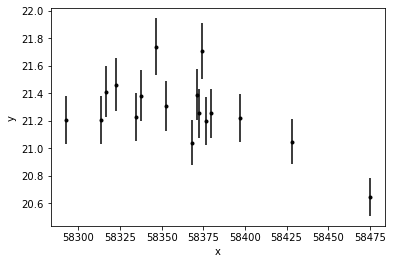

In [52]:
# import numpy as np
# import matplotlib.pyplot as plt
# np.random.seed(42)

# t = np.sort(np.append(
#     np.random.uniform(0, 3.8, 57),
#     np.random.uniform(5.5, 10, 68),
# ))  # The input coordinates must be sorted
# yerr = np.random.uniform(0.08, 0.22, len(t))
# y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

# true_t = np.linspace(0, 10, 5000)
# true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5);

In [53]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

In [54]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -0.8752749623539664


In [55]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: 0.4007800640911565
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.68434192e-06,  1.49213974e-05])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 126
      nit: 9
     njev: 42
   status: 2
  success: False
        x: array([-3.75311758,  0.710519  ])


In [56]:
x = np.linspace(t[0], t[-1], 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

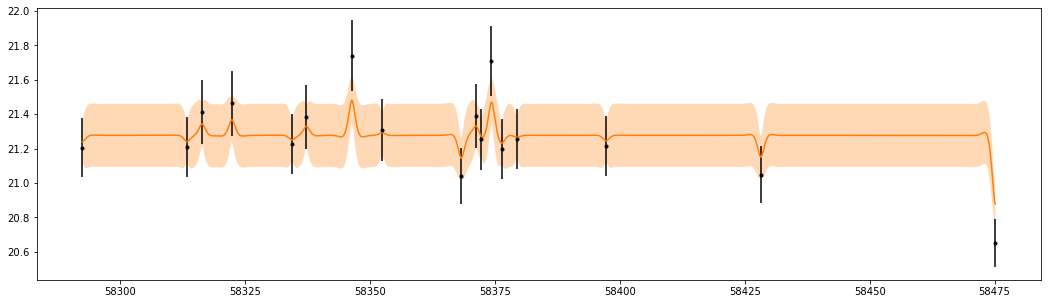

In [57]:
color = "#ff7f0e"
fig, ax = plt.subplots(1,1, figsize=(18, 5))
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x, pred_mean, color=color)
ax.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")